In [1]:
import numpy as np
import os
from configparser import ConfigParser
from visualization import load_depth
import visualization
from PIL import Image
import pickle
import json
import time
from shutil import copyfile
import moviepy
from moviepy.editor import *

In [2]:
ini_file = "gta-postprocessing.ini"
visualization.multi_page = False
visualization.ini_file = ini_file
visualization.use_cache = False

conn = visualization.get_connection()
cur = conn.cursor()

CONFIG = ConfigParser()
CONFIG.read(ini_file)
in_directory = r'D:\generic-dataset-ota'
out_directory = r'D:\showing-pointclouds'


In [3]:
#run_id = 19
run_id = 3677

cur.execute("""SELECT imagepath, \
      ARRAY[st_x(camera_relative_rotation), st_y(camera_relative_rotation), st_z(camera_relative_rotation)] as camera_relative_rotation
      FROM snapshots \
      WHERE run_id = {} AND camera_fov != 0 \
      ORDER BY timestamp ASC \
    """.format(run_id))
# camera fov is sanity check for malformed images
results = []
for row in cur:
    res = dict(row)
    #res['camera_relative_rotation'] = np.array(res['camera_relative_rotation'])
    results.append(res)

print('There are {} snapshots'.format(len(results)))

There are 3817 snapshots


In [4]:
def split_results_by_relative_cam_rot(results):
    cam_rotations = [
        [0, 0, 0],
        [0, 0, 90],
        [0, 0, 180],
        [0, 0, 270],
    ]
    res_groups = {}
    for cam_rot in cam_rotations:
        res_groups[str(cam_rot)] = [i for i in results if i['camera_relative_rotation'] == cam_rot]
    return res_groups


def result_group_to_video(results, suffix):
    img_sequence = [os.path.join(in_directory, i['imagepath']+suffix) for i in results]
    clip = ImageSequenceClip(img_sequence, fps=10)
    return clip

def result_depth_group_to_video(results, suffix):
    img_sequence = [os.path.join(in_directory, i['imagepath']+suffix) for i in results]
    img_sequence = [np.array(Image.open(i).convert('RGB')) for i in img_sequence]
    clip = ImageSequenceClip(img_sequence, fps=10)
    return clip

### preparing data

In [5]:
result_groups = split_results_by_relative_cam_rot(results)


In [6]:
for cam_rot, res in result_groups.items():
    print(cam_rot)
    print(len(res))

[0, 0, 0]
959
[0, 0, 90]
953
[0, 0, 180]
954
[0, 0, 270]
951


### dumping data to videos

In [7]:
for cam_rot, res in result_groups.items():
    clip = result_group_to_video(res, '.png')
    depth_clip = result_depth_group_to_video(res, '-depth.png')
    video_name = os.path.join(out_directory, "camera-{}.mp4".format(cam_rot))
    clip.write_videofile(video_name, audio=False, codec='mpeg4')
    video_name = os.path.join(out_directory, "camera-{}-depth.mp4".format(cam_rot))
    depth_clip.write_videofile(video_name, audio=False, codec='mpeg4')

[MoviePy] >>>> Building video D:\showing-pointclouds\camera-[0, 0, 0].mp4
[MoviePy] Writing video D:\showing-pointclouds\camera-[0, 0, 0].mp4


100%|█████████████████████████████████████████████████████████████████████████████| 959/959 [01:48<00:00,  8.83it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: D:\showing-pointclouds\camera-[0, 0, 0].mp4 

[MoviePy] >>>> Building video D:\showing-pointclouds\-[0, 0, 0]-depth.mp4
[MoviePy] Writing video D:\showing-pointclouds\-[0, 0, 0]-depth.mp4


100%|█████████████████████████████████████████████████████████████████████████████| 959/959 [00:11<00:00, 86.61it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: D:\showing-pointclouds\-[0, 0, 0]-depth.mp4 

[MoviePy] >>>> Building video D:\showing-pointclouds\camera-[0, 0, 90].mp4
[MoviePy] Writing video D:\showing-pointclouds\camera-[0, 0, 90].mp4


100%|█████████████████████████████████████████████████████████████████████████████| 953/953 [01:53<00:00,  8.37it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: D:\showing-pointclouds\camera-[0, 0, 90].mp4 

[MoviePy] >>>> Building video D:\showing-pointclouds\-[0, 0, 90]-depth.mp4
[MoviePy] Writing video D:\showing-pointclouds\-[0, 0, 90]-depth.mp4


100%|█████████████████████████████████████████████████████████████████████████████| 953/953 [00:12<00:00, 78.08it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: D:\showing-pointclouds\-[0, 0, 90]-depth.mp4 



KeyboardInterrupt: 

In [37]:
name = os.path.join(in_directory, result_groups['[0, 0, 0]'][0]['imagepath']+'-depth.png')
depth_arr = np.array(Image.open(name).convert('RGB'))
depth_arr_2 = np.array(Image.open(name).convert('L').convert('RGB'))
depth_arr_3 = np.array(Image.open(name).convert('L'))
arr_single = np.array(Image.open(name))

In [38]:
depth_arr.max()

255

In [39]:
arr_single.max()

46909

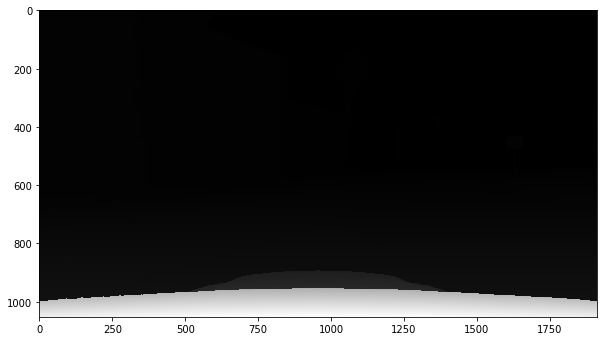

In [40]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))
plt.imshow(arr_single, cmap='gray')
plt.show()

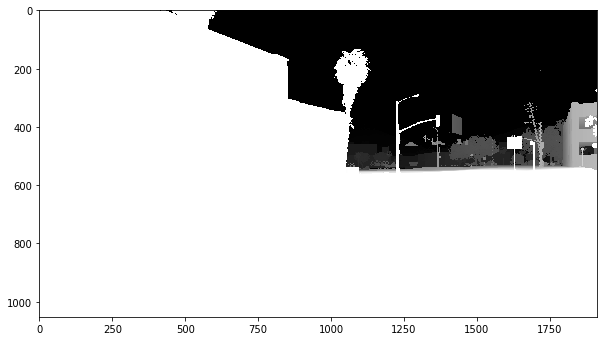

In [55]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(depth_arr_3, cmap='gray')
plt.show()

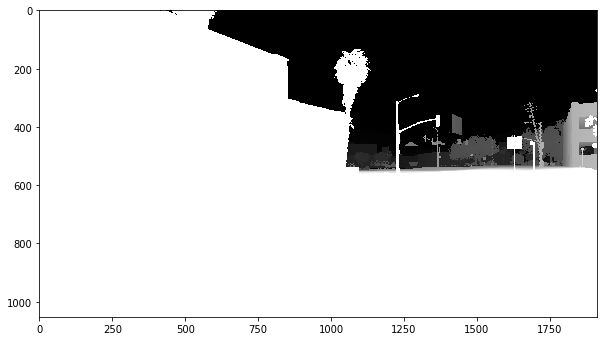

In [58]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(depth_arr_2)
plt.show()

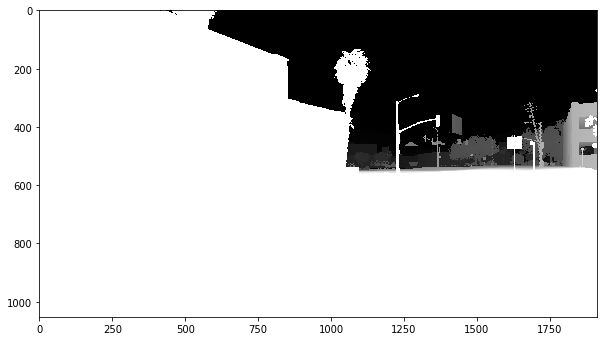

In [43]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(depth_arr)
plt.show()

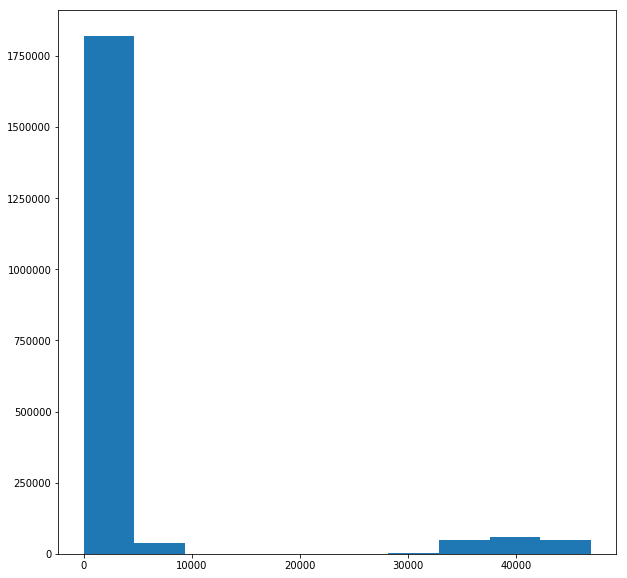

In [44]:
fig = plt.figure(figsize=(10, 10))
plt.hist(arr_single.flatten())
plt.show()

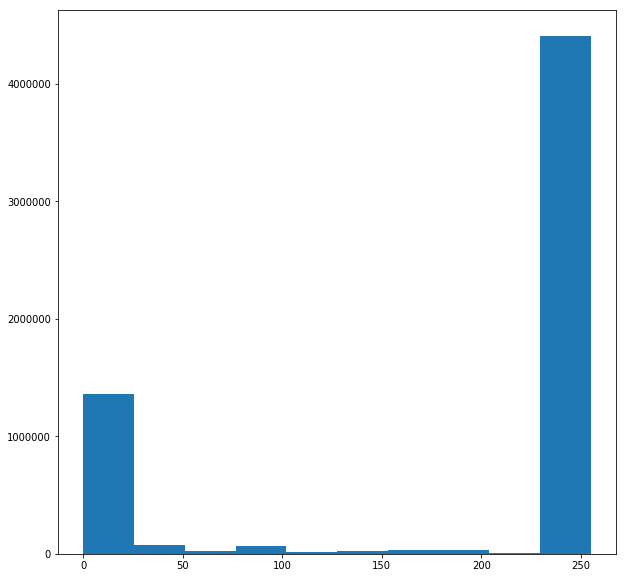

In [45]:
fig = plt.figure(figsize=(10, 10))
plt.hist(depth_arr.flatten())
plt.show()

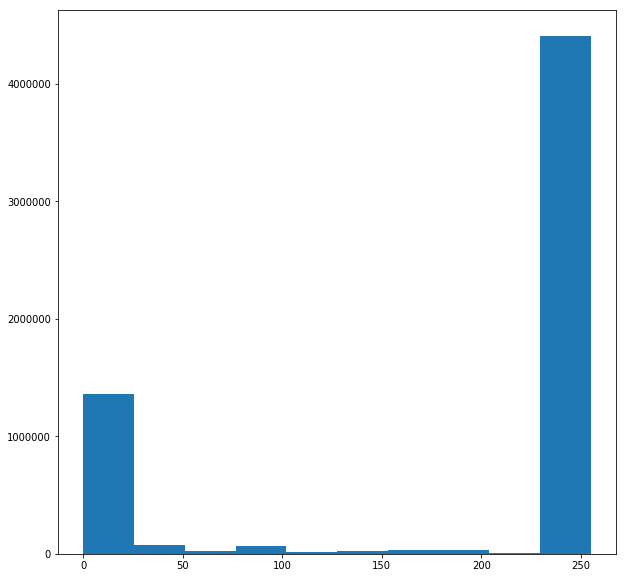

In [46]:
fig = plt.figure(figsize=(10, 10))
plt.hist(depth_arr_2.flatten())
plt.show()

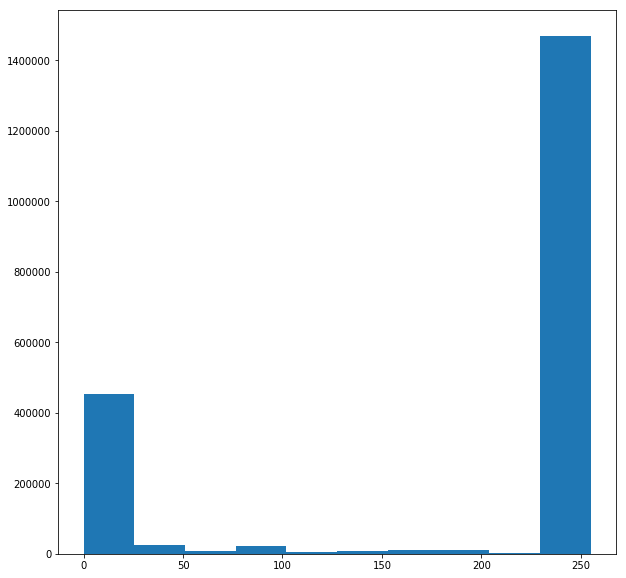

In [47]:
fig = plt.figure(figsize=(10, 10))
plt.hist(depth_arr_3.flatten())
plt.show()

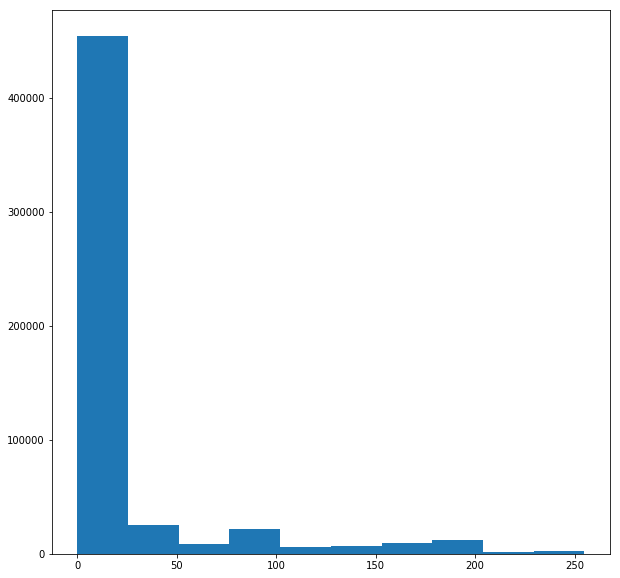

In [48]:
arr_single_cropped = arr_single[arr_single < 256]
fig = plt.figure(figsize=(10, 10))
plt.hist(arr_single_cropped.flatten())
plt.show()